# Import Necessary Libraries

In [ ]:
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from keras.applications.mobilenet import MobileNet
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [ ]:
pip install tensorflow

In [ ]:
!pip install keras_preprocessing


# Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load the CSV file
csv_file_path = '/content/drive/MyDrive/nih_new/Data_Entry_2017_v2020.csv'  # Update this path to the location of your CSV file
all_xray_df = pd.read_csv(csv_file_path)

# Create a dictionary of image paths with filenames as keys
# This assumes that your images are in a folder structure like '../input/images_*/images/*.png'
all_image_paths = {os.path.basename(x): x for x in
                   glob(os.path.join('..', 'input', 'images*', 'images', '*.png'))}

# Report how many images were found
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])

# Map the 'Image Index' from the CSV to the paths in the dictionary
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

# Convert 'Patient Age' to integer by removing the last character and converting to int
# This assumes that the 'Patient Age' column contains strings with the last character being a non-numeric character
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]) if isinstance(x, str) else x)

# Display a sample of the DataFrame to ensure it looks correct
print(all_xray_df.sample(3))


Scans found: 0 , Total Headers 112120
            Image Index            Finding Labels  Follow-up #  Patient ID  \
64250  00015847_003.png  Atelectasis|Infiltration            1       15847   
74969  00018387_005.png                No Finding            5       18387   
76867  00018867_032.png                No Finding           32       18867   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
64250           41              F            AP                 2500     2048   
74969           57              M            AP                 2500     2048   
76867           33              F            AP                 3056     2544   

       OriginalImagePixelSpacing[x     y]  path  
64250                        0.168  0.168  None  
74969                        0.168  0.168  None  
76867                        0.139  0.139  None  


# Data Visualization

In [ ]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
25018,00006588_001.png,,1,6588,41,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21068,00005626_009.png,Consolidation,9,5626,34,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2941,00000781_002.png,Nodule,9,781,71,F,PA,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


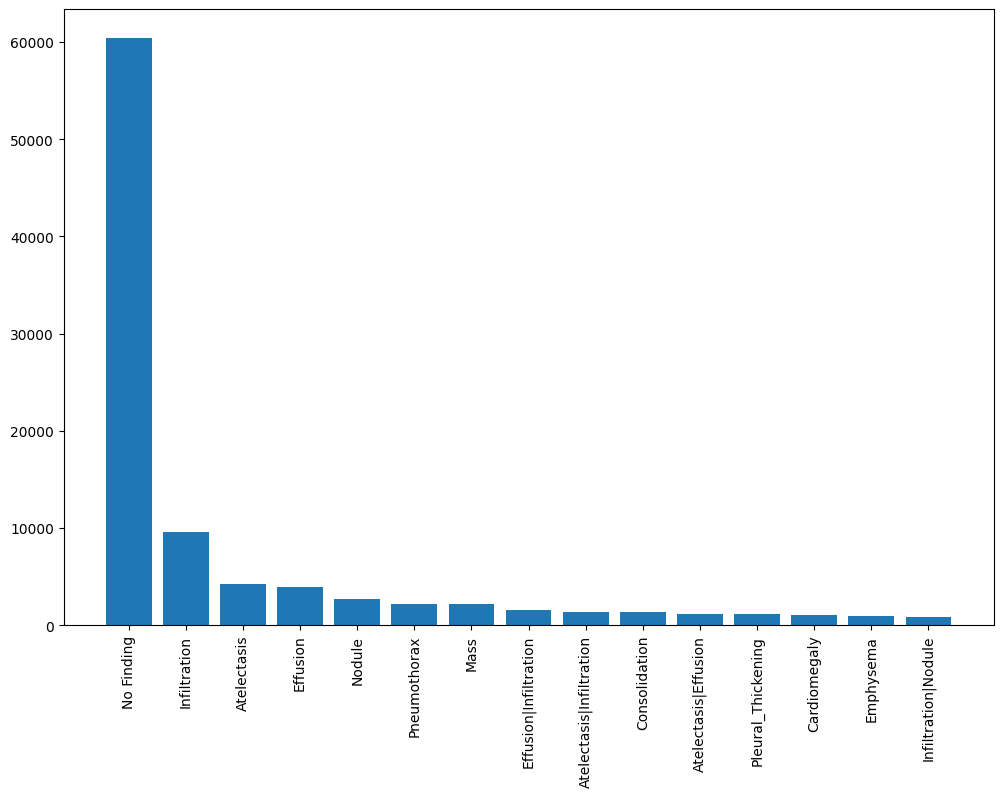

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

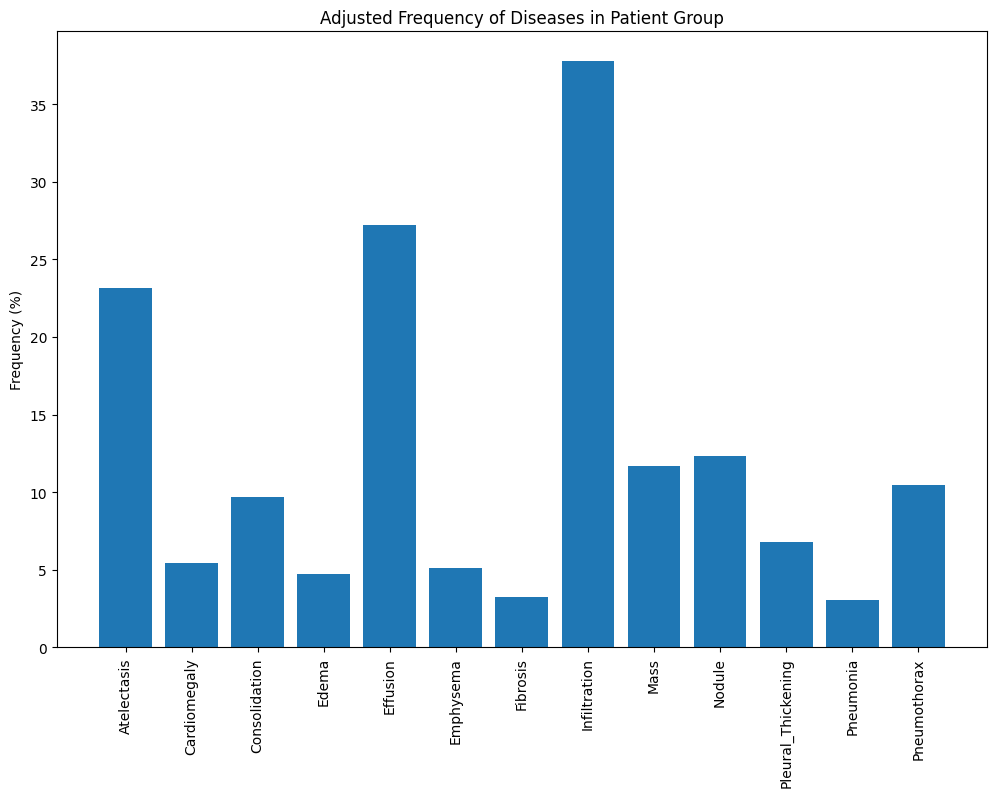

In [ ]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

In [ ]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)),
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 11559), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2303), ('Effusion', 13317), ('Emphysema', 2516), ('Fibrosis', 1686), ('Infiltration', 19894), ('Mass', 5782), ('Nodule', 6331), ('Pleural_Thickening', 3385), ('Pneumonia', 1431), ('Pneumothorax', 5302)]


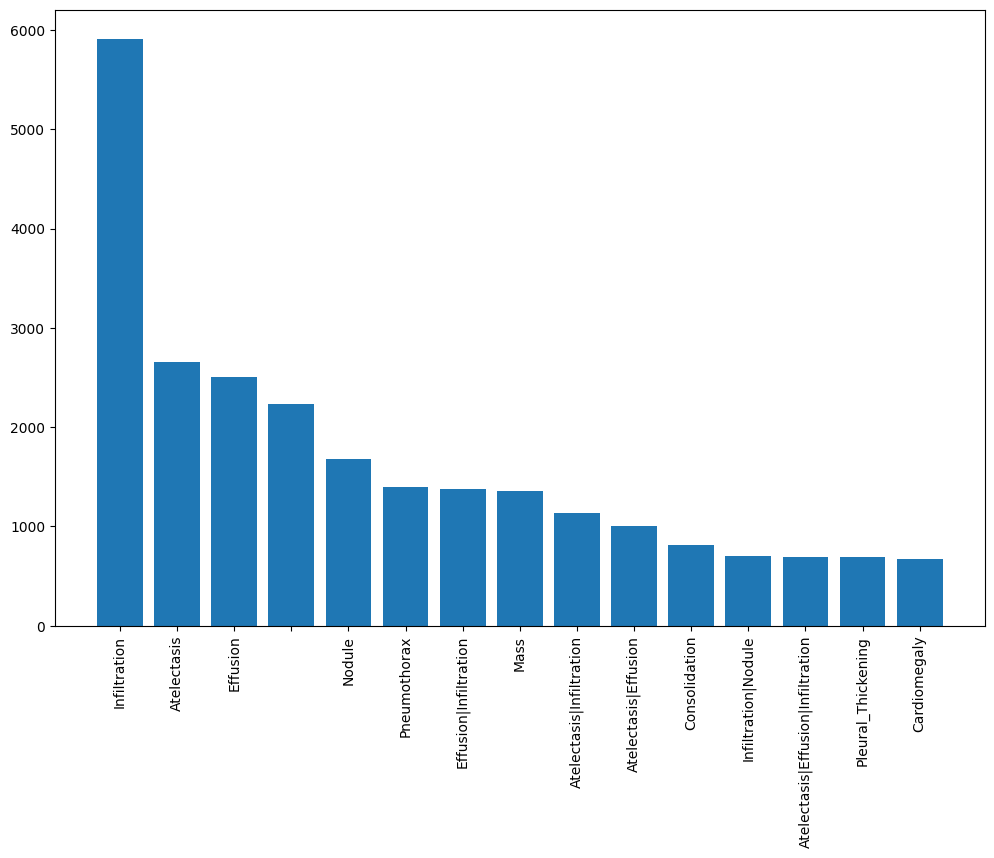

In [ ]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(40000, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

# Train-Test split



In [ ]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [ ]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df,
                                   test_size = 0.25,
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])


train 30000 validation 10000


# DATA AUGMNENTATION

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

# LOADING IMAGES ACCORDING TO ITS LABELS

In [ ]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir,
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen


In [ ]:
# Remove rows with missing paths in 'train_df'
train_df = train_df.dropna(subset=['path'])

# Remove rows with missing paths in 'valid_df'
valid_df = valid_df.dropna(subset=['path'])

# Verify that the rows have been removed
print(train_df['path'].isnull().sum())  # Should output 0
print(valid_df['path'].isnull().sum())  # Should output 0


0
0


In [ ]:
# Assuming your images are in the 'images' folder in the same directory as your CSV
image_folder_path = '/content/drive/MyDrive/nih_new/images-small/CXR8/images'

# Create a dictionary of image paths with filenames as keys
all_image_paths = {os.path.basename(x): os.path.join(image_folder_path, x) for x in os.listdir(image_folder_path)}
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

# Check for any missing paths
print(f"Number of missing paths: {all_xray_df['path'].isnull().sum()}")

# Display the DataFrame to verify the 'path' column
print(all_xray_df.head())


Number of missing paths: 40000
            Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
66994  00016564_001.png   Cardiomegaly            0       16564           59   
9899   00002569_000.png    Atelectasis            0        2569           53   
93458  00023392_000.png                           0       23392           32   
10463  00002706_006.png   Infiltration            6        2706           51   
6176   00001673_001.png         Nodule           17        1673           38   

      Patient Gender View Position  OriginalImage[Width  Height]  \
66994              F            PA                 3056     2468   
9899               M            PA                 2500     2048   
93458              F            PA                 2048     2500   
10463              F            AP                 2500     2048   
6176               F            PA                 2021     2021   

       OriginalImagePixelSpacing[x  ...  Emphysema Fibrosis  Hernia  \
66994   

# CREATING DATAFRAME

In [ ]:
import pandas as pd

# Replace with the correct path to your CSV file
csv_file_path = '/content/drive/MyDrive/nih_new/Data_Entry_2017_v2020.csv'

# Read the CSV file again
train_df = pd.read_csv(csv_file_path)

# Verify that the DataFrame is not empty
if train_df.empty:
    raise ValueError(f"The CSV file at {csv_file_path} is empty or not read correctly.")

# If the DataFrame is not empty, display the first few rows to confirm
print("First few rows of train_df after re-reading the CSV:")
print(train_df.head())

# Continue with the rest of your code if the DataFrame is correctly loaded



First few rows of train_df after re-reading the CSV:
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_001.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           57              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           80              M            PA                 2500     2048   
4           74              F            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  
0          

# IMAGE VALIDATION

In [ ]:
import os

def list_directories_and_files(path):
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')

# Replace 'your_directory_path' with the path to your dataset directory
your_directory_path = '/content/drive/MyDrive/nih_new'
list_directories_and_files(your_directory_path)



Streaming output truncated to the last 5000 lines.
                            00001075_039.png
                            00001104_021.png
                            00001112_000.png
                            00001104_002.png
                            00001104_003.png
                            00001075_034.png
                            00001101_011.png
                            00001101_013.png
                            00001088_001.png
                            00001075_044.png
                            00001104_016.png
                            00001101_022.png
                            00001082_006.png
                            00001081_002.png
                            00001104_000.png
                            00001104_007.png
                            00001101_020.png
                            00001093_013.png
                            00001108_002.png
                            00001079_000.png
                            00001086_001.png
    

# EXTRACTION OF TAR.GZ FILES

In [ ]:
import tarfile
import os

def extract_tar_gz(tar_path, extract_path):
    if tar_path.endswith("tar.gz"):
        tar = tarfile.open(tar_path, "r:gz")
        tar.extractall(path=extract_path)
        tar.close()
        print(f"Extracted {tar_path} to {extract_path}")
    else:
        print(f"{tar_path} is not a tar.gz file")

# Replace 'your_tar_gz_path' with the path to one of your .tar.gz files
# Replace 'your_extract_path' with the path where you want to extract the images
your_tar_gz_path = '/content/drive/MyDrive/App_Backup_Restore/finall/CXR8/images/images_001.tar.gz'
your_extract_path = '/content/drive/MyDrive/App_Backup_Restore/finall/CXR8/images/extracted/'

extract_tar_gz(your_tar_gz_path, your_extract_path)


In [ ]:
import os

# Assuming 'Image Index' contains the image filenames and 'image_directory' is the path to your image folder
image_directory = '/content/drive/MyDrive/nih_new/images-small/CXR8/images/extracted/'  # Update this with the actual path to your images
train_df['path'] = train_df['Image Index'].apply(lambda x: os.path.join(image_directory, x))


# FINDING LABELS

In [ ]:
 from sklearn.preprocessing import MultiLabelBinarizer

# Assuming 'Finding Labels' contains the labels separated by a pipe '|'
labels = train_df['Finding Labels'].str.split('|').apply(lambda x: x if isinstance(x, list) else [])

# Create a MultiLabelBinarizer object
mlb = MultiLabelBinarizer()

# One-hot encode the labels
train_df['disease_vec'] = list(mlb.fit_transform(labels))

# Check the new column
print(train_df[['Finding Labels', 'disease_vec']].head())


           Finding Labels                                    disease_vec
0            Cardiomegaly  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
1  Cardiomegaly|Emphysema  [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2   Cardiomegaly|Effusion  [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
3              No Finding  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
4                  Hernia  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# Suppose your images are stored in '/content/drive/MyDrive/images/'
# and the 'path' column contains only filenames like 'image1.jpg'
image_directory = '/content/drive/MyDrive/nih_new/images-small/CXR8/images/'

# Update the 'path' column with the full path
train_df['path'] = image_directory + train_df['path']


In [ ]:
print("First few rows of train_df:")
print(train_df.head())

print("First few rows of valid_df:")
print(valid_df.head())


First few rows of train_df:
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_001.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           57              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           80              M            PA                 2500     2048   
4           74              F            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  \
0                        0.143  0.1

# TRAIN AND VALIDATION SPLIT

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_df, valid_df = train_test_split(all_xray_df,
                                      test_size=0.25,
                                      random_state=2018,
                                      stratify=all_xray_df['Finding Labels'].map(lambda x: x[:4]))

print('train', train_df.shape[0], 'validation', valid_df.shape[0])


train 30000 validation 10000


# REINSERTING DATAFRAME

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np

def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir,
                                              class_mode='sparse',
                                              **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = ''  # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen


# LOADING IMAGES FROM THE DICTIONARY

In [ ]:
import os
import cv2
import numpy as np

# Define the directory path
directory_path = '/content/drive/MyDrive/nih_new/images-small/CXR8/images'

# Initialize an empty list to store images
images = []

# Loop through the files in the directory
for filename in os.listdir(directory_path):
    if filename.endswith(".jpg"):  # You can specify the file extensions you want to load
        filepath = os.path.join(directory_path, filename)
        img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  # Read the image in grayscale
        if img is not None:
            images.append(img)

# Now, the 'images' list contains all the loaded images from the directory


In [ ]:
print(df.head())


        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_001.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           57              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           80              M            PA                 2500     2048   
4           74              F            PA                 2500     2048   

   OriginalImagePixelSpacing[x     y]  
0                        0.143  0.143  
1                       

# PREDICTING LABELS

In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/nih_new/Data_Entry_2017_v2020.csv')

nique_labels = set()
for labels in df['Finding Labels'].str.split('|'):
    unique_labels.update(labels)

all_labels = sorted(list(unique_labels))
print(all_labels)


['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


# MODEL TRAINING

In [ ]:
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define paths and constants
TRAIN_DIR = '/content/drive/MyDrive/nih_new/image-small/CXR8/images/extracted/images/train'
VALID_DIR = '/content/drive/MyDrive/nih_new/image-small/finall/CXR8/images/extracted/images/valid'
CSV_FILE_PATH = '/content/drive/MyDrive/nih_new/Data_Entry_2017_v2020.csv'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Check if directories exist
if not os.path.isdir(TRAIN_DIR):
    raise Exception("Training directory does not exist.")
if not os.path.isdir(VALID_DIR):
    raise Exception("Validation directory does not exist.")

# Load dataset CSV file
if not os.path.isfile(CSV_FILE_PATH):
    raise Exception("CSV file does not exist.")
df = pd.read_csv(CSV_FILE_PATH)

# Check if 'Image Index' and 'Finding Labels' columns exist
if 'Image Index' not in df.columns or 'Finding Labels' not in df.columns:
    raise Exception("Required columns are missing from the dataset.")

# Define class labels and verify
all_labels = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema",
              "Fibrosis", "Infiltration", "Mass", "Nodule", "Pleural Thickening", "Pneumonia",
              "Pneumothorax"]
if not set(all_labels).issubset(df['Finding Labels'].str.split('|').explode().unique()):
    raise Exception("One or more class labels do not match the dataset.")

# Split the dataset
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Verify image files exist
missing_files = train_df['Image Index'].apply(lambda x: not os.path.isfile(os.path.join(TRAIN_DIR, x)))
if missing_files.any():
    raise Exception("Some image files are missing in the training set.")
missing_files = valid_df['Image Index'].apply(lambda x: not os.path.isfile(os.path.join(VALID_DIR, x)))
if missing_files.any():
    raise Exception("Some image files are missing in the validation set.")

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR,
    x_col='Image Index',
    y_col=all_labels,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='raw'
)

valid_gen = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=VALID_DIR,
    x_col='Image Index',
    y_col=all_labels,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='raw'
)

# Model with VGG16 base
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(all_labels), activation='sigmoid')
])

model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True),
    ModelCheckpoint('/content/drive/MyDrive/best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)
]

# Training the model
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=1,  # You can adjust the number of epochs based on the training progress
    validation_data=valid_gen,
    validation_steps=len(valid_gen),
    callbacks=callbacks
)

# Save the model
model.save('/content/drive/MyDrive/final_cnn_model.h5')

import json
with open('/content/drive/MyDrive/training_history.json', 'w') as f:
    json.dump(history.history, f)

print("Model and training history have been saved.")



# PREDICTION OF THE INPUT IMAGE

In [ ]:
import cv2
import numpy as np

# Load and preprocess the image
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = cv2.resize(image, (224, 224))  # Resize to the size your model expects
    image = image / 255.0  # Normalize pixel values to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image
sample_image_path = '/content/drive/MyDrive/pne.jpg'
sample_image = load_and_preprocess_image(sample_image_path)
predictions = model.predict(sample_image)

# Display the class labels and their probabilities for the sample image
for label, probability in zip(all_labels, predictions[0]):
    print(f"{label} is: {probability * 100:.2f}%")


1/1 [==============================] - 1s 1s/step
Atelectasis is: 4.71%
Cardiomegaly is: 4.77%
Consolidation is: 3.33%
Edema is: 1.59%
Effusion is: 4.76%
Emphysema is: 2.35%
Fibrosis is: 3.37%
Hernia is: 1.23%
Infiltration is: 20.67%
Mass is: 3.75%
No Finding is: 47.74%
Nodule is: 4.68%
Pleural Thickening is: 5.28%
Pneumonia is: 0.95%
Pneumothorax is: 3.63%


# CLASS ACTIVATION MAP OUTPUT

1/1 [==============================] - 1s 512ms/step


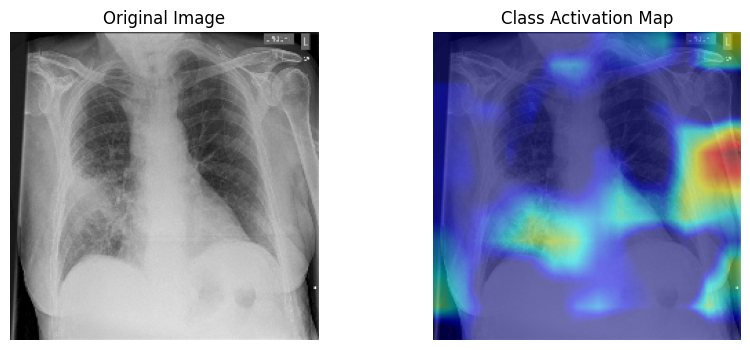

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

# Assuming that '/content/drive/MyDrive/final_cnn_model.h5' is the path to your trained model
model_path = '/content/drive/MyDrive/final_cnn_model.h5'
model = load_model(model_path)

# Define the path to your image
image_path = '/content/drive/MyDrive/pne.jpg'

# Define a function to load and preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Load and preprocess the image
img_array = preprocess_image(image_path)

# Make a prediction
predictions = model.predict(img_array)

# Get the weights of the output layer
output_weights = model.layers[-1].get_weights()[0]

# Assuming 'model' is your pre-trained model
# Extract the vgg16 part from your model
vgg16_model = model.get_layer('vgg16')

# The actual last conv layer name in the standard VGG16 model is 'block5_conv3'
# We will use this to get the last conv layer from the vgg16 part
last_conv_layer = vgg16_model.get_layer('block5_conv3')

# Now, let's create a new model that outputs the last_conv_layer's activations
last_conv_layer_model = tf.keras.Model(inputs=vgg16_model.input, outputs=last_conv_layer.output)

# Now we create the CAM for the last conv layer's output
last_conv_output = last_conv_layer_model.predict(img_array)
last_conv_output = last_conv_output[0]  # Remove batch dimension

# Assuming the dense layer after flattening is named 'dense_3' and it's the output layer
# Get the weights for the class index from the final dense layer (output layer)
weights = model.get_layer('dense_3').get_weights()[0]

# Generate the CAM as before
class_idx = np.argmax(predictions[0])  # Index of the predicted class
cam = np.dot(last_conv_output, weights[:, class_idx])
cam = cv2.resize(cam, (224, 224))
cam = np.maximum(cam, 0)
cam = cam / cam.max()

# ... (rest of the CAM visualization code remains the same)


# We use the 'block5_conv3' layer for VGG16
last_conv_output = last_conv_layer_model.predict(img_array)
last_conv_output = last_conv_output[0]

# Create the class activation map
cam = np.dot(last_conv_output, output_weights[:, class_idx])

# Resize the CAM to 224x224
cam = cv2.resize(cam, (224, 224))

# ReLU activation to get the positive influence on the class prediction
cam = np.maximum(cam, 0)

# Normalize the CAM
cam /= np.max(cam)

# Convert to uint8 and apply colormap
cam = np.uint8(255 * cam)
heatmap = cv2.applyColorMap(cam, cv2.COLORMAP_JET)

# Superimpose the heatmap onto the original image
original_img = cv2.imread(image_path)
original_img = cv2.resize(original_img, (224, 224))
superimposed_img = heatmap * 0.5 + original_img * 0.5
superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

# Display the original image and the CAM
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title('Class Activation Map')
plt.axis('off')

plt.show()


# GRAPHLY REPRESENTATION OF PREDICTED PROBABLITIES


1/1 [==============================] - 1s 1s/step


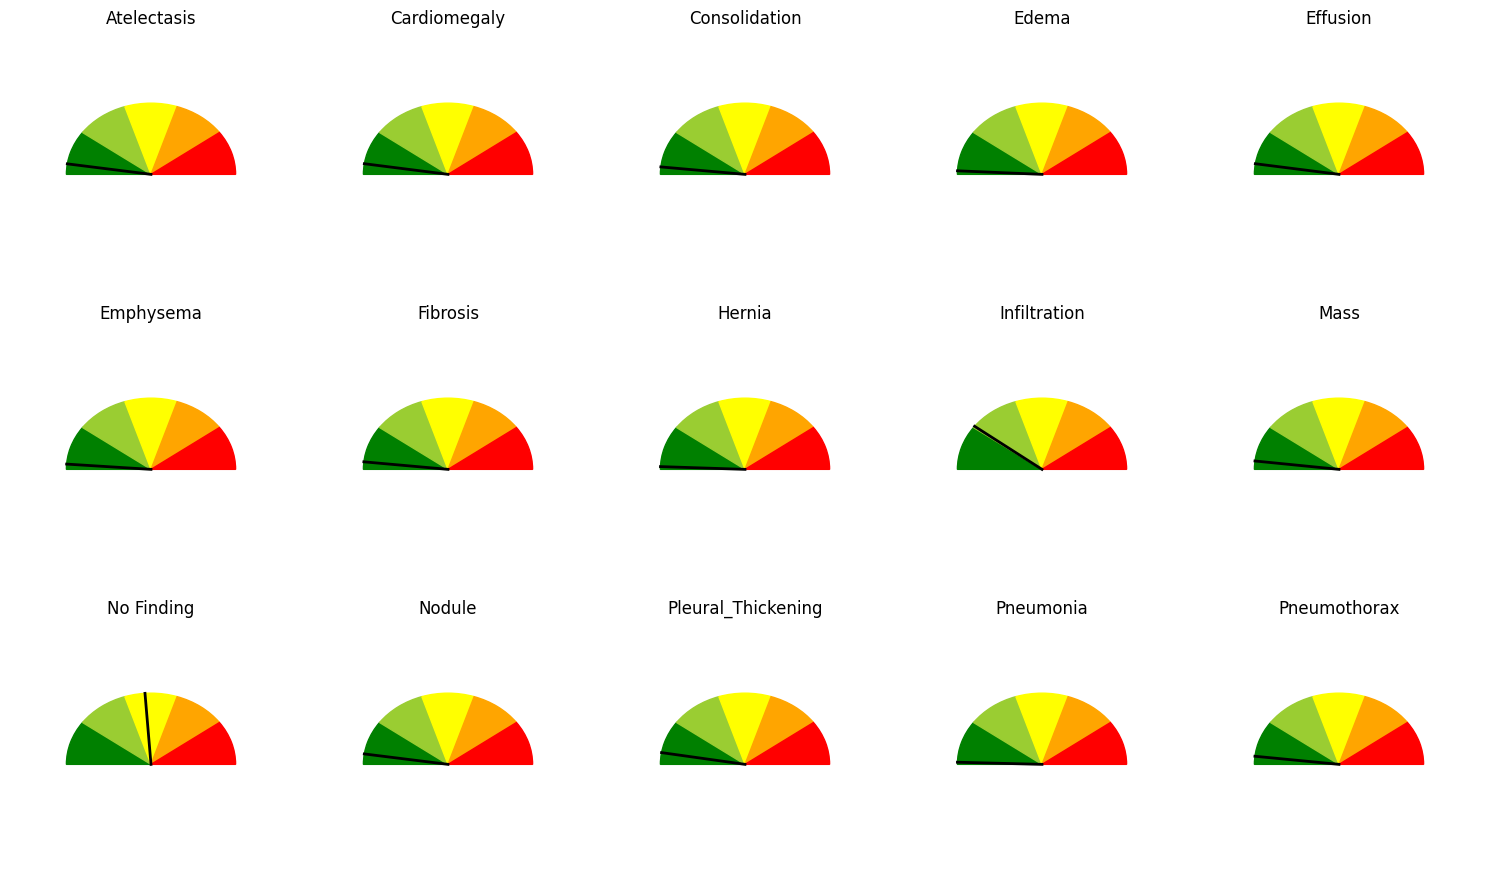

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge, Circle

# Define the function to draw a single speedometer gauge
def draw_speedometer(percentage, ax, label):
    # Define the range of the speedometer
    start_angle = 180
    end_angle = 0
    range_angles = [start_angle, 144, 108, 72, 36, end_angle]  # Divide the gauge into sections
    colors = ["#008000", "#9ACD32", "#FFFF00", "#FFA500", "#FF0000"]  # Define the colors

    # Draw the colored sections of the gauge
    for i, color in enumerate(colors):
        ang1, ang2 = range_angles[i], range_angles[i+1]
        ax.add_patch(Wedge(center=(0.5, 0.5), r=0.3, theta1=ang2, theta2=ang1, color=color))

    # Draw the needle
    value_angle = start_angle - (percentage / 100.0) * 180
    x = 0.5 + 0.3 * np.cos(np.radians(value_angle))
    y = 0.5 + 0.3 * np.sin(np.radians(value_angle))
    ax.plot([0.5, x], [0.5, y], color='black', lw=2)  # Needle

    # Set the title of the gauge as the label
    ax.set_title(label, y=1.1)

    # Remove the axes
    ax.axis('off')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

# Load and preprocess the image
sample_image_path = '/content/drive/MyDrive/pne.jpg'
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
sample_image = cv2.resize(sample_image, (224, 224))  # Assuming your model expects 224x224 input
sample_image = sample_image / 255.0  # Normalize pixel values to [0, 1]
sample_image = np.expand_dims(sample_image, axis=0)  # Add batch dimension

# Make predictions using the model
# Replace 'model' with your actual model and 'all_labels' with the actual labels
predictions = model.predict(sample_image)[0]

# Visualize the predictions as speedometer gauges
fig, axs = plt.subplots(3, 5, figsize=(15, 9))  # Adjust the layout as needed
axs = axs.flatten()  # Flatten the 2D array of axes

# Draw a speedometer gauge for each prediction and label
for ax, label, probability in zip(axs, all_labels, predictions):
    draw_speedometer(probability * 100, ax, label)

plt.tight_layout()
plt.show()


# PREDICTED PROBABLITIES VS GLOBAL AVERAGE

1/1 [==============================] - 1s 633ms/step


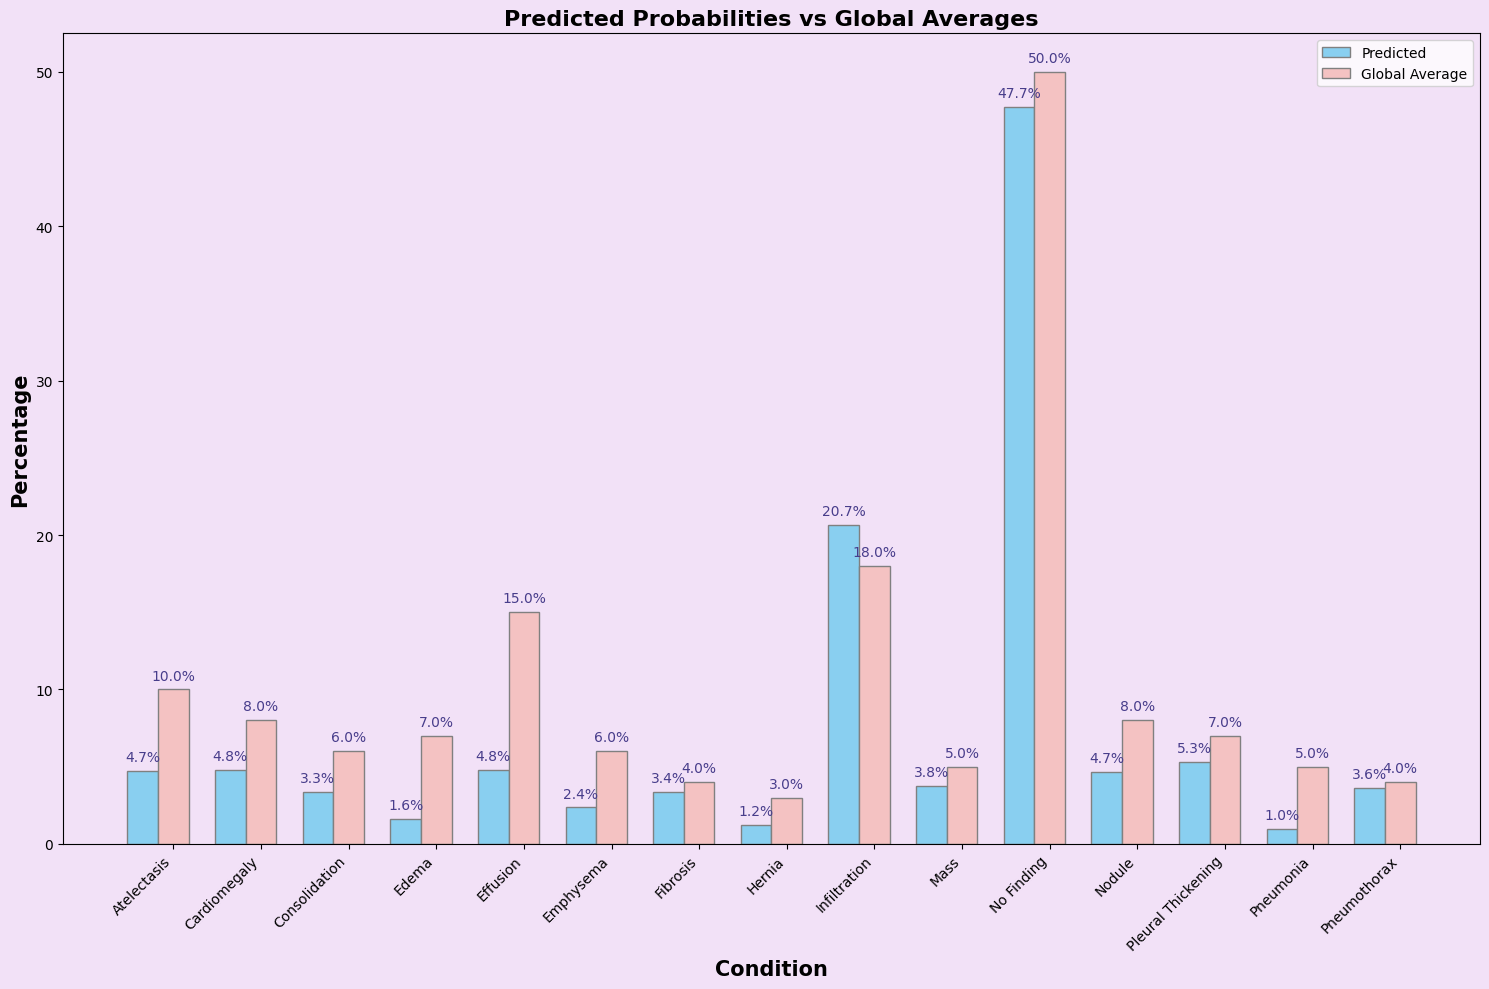

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import load_model

# Load your trained model
model_path = '/content/drive/MyDrive/final_cnn_model.h5'
model = load_model(model_path)

# Define your class labels
all_labels = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
    'Nodule', 'Pleural Thickening', 'Pneumonia', 'Pneumothorax'
]

# Load and preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    return img

sample_image_path = '/content/drive/MyDrive/pne.jpg'
img = preprocess_image(sample_image_path)
img_array = np.expand_dims(img, axis=0)  # Add batch dimension

# Generate predictions for the sample image
predictions = model.predict(img_array)[0] * 100  # Convert predictions to percentages

# Mock higher global average percentages for each condition (replace these with actual data)
global_averages = np.array([
    10, 8, 6, 7, 15, 6, 4, 3, 18, 5, 50, 8, 7, 5, 4
])

# Create a DataFrame for the predictions and global averages
data = pd.DataFrame({
    'Condition': all_labels,
    'Predicted Probability': predictions,
    'Global Average': global_averages
})

# Plotting side-by-side bar graph with a light purple background
fig, ax = plt.subplots(figsize=(15, 10))
fig.patch.set_facecolor('#F2E1F7')  # Set the background color of the figure to light purple
ax.set_facecolor('#F2E1F7')  # Set the background color of the axes to light purple

# Set position of bar on X axis
bar_width = 0.35
r1 = np.arange(len(data['Condition']))
r2 = [x + bar_width for x in r1]

# Make the plot
ax.bar(r1, data['Predicted Probability'], color='#89CFF0', width=bar_width, edgecolor='grey', label='Predicted')  # Soft blue
ax.bar(r2, data['Global Average'], color='#F4C2C2', width=bar_width, edgecolor='grey', label='Global Average')  # Soft pink

# Add labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Condition', fontweight='bold', fontsize=15)
ax.set_ylabel('Percentage', fontweight='bold', fontsize=15)
ax.set_title('Predicted Probabilities vs Global Averages', fontweight='bold', fontsize=16)
ax.set_xticks([r + bar_width for r in range(len(r1))])
ax.set_xticklabels(data['Condition'], rotation=45, ha='right')
ax.legend()

# Create labels on top of the bars
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'
        label = "{:.1f}%".format(y_value)
        ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va=va, color='darkslateblue')

# Call functions to implement the function calls
add_value_labels(ax)

plt.tight_layout()
plt.show()
